<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b>Investigate centerAll-flagged sources in AP data</b> <br>
Contact author: Ian Sullivan<br>
Last verified to run: 04 January 2024<br>
LSST Science Piplines version: d_2024_01_31<br>
Run at USDF on the "2021 Diffim Sprint" HSC dataset


## Run details

Baseline run in comparison with pre-convolution

* Used daily `d_2024_01_31` for both, with the centerAll flags addded to the pipeline .yaml for the comparison run
* rbClassifier_data set up locally
* Run at USDF:  /sdf/data/rubin/user/sullii/tickets/DM-41875/submit/u/sullii/DM-41875/HSC/main/20240131T191654Z and /sdf/data/rubin/user/sullii/tickets/DM-41875/submit/u/sullii/DM-41875/HSC/centerAll/20240201T201645Z



### 1. Main package imports

In [3]:
import os
import importlib
import pprint

In [4]:
import matplotlib.pyplot as plt
#%matplotlib widget
%matplotlib inline

import numpy as np
import pandas as pd

In [5]:
import astropy.units as u
from astropy.coordinates import SkyCoord

In [6]:
import lsst.afw.display as afwDisplay
import lsst.geom

import lsst.daf.butler as dafButler
import lsst.pipe.base

In [7]:
!eups list analysis_ap

   LOCAL:/home/s/sullii/project/build/analysis_ap 	setup


In [9]:
from lsst.analysis.ap import apdb

In [10]:
from lsst.analysis.ap import legacyApdbUtils as utils
from lsst.analysis.ap import legacyPlotUtils as plac
from lsst.analysis.ap import nb_utils

In [11]:
from astropy.table import Table

In [12]:
importlib.reload(plac)

<module 'lsst.analysis.ap.legacyPlotUtils' from '/home/s/sullii/project/build/analysis_ap/python/lsst/analysis/ap/legacyPlotUtils.py'>

In [13]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

importlib.reload(utils)

<module 'lsst.analysis.ap.legacyApdbUtils' from '/home/s/sullii/project/build/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py'>

### 2. Data access config
We are comparing multiple runs now, so we have to define where to find the data and the APDBs for each run.

#### Keys for default run.

In [14]:
repo = '/repo/main'
instrument = 'HSC'
skymap = 'hsc_rings_v1'

dbType='postgres'
dbName='postgresql://rubin@usdf-prompt-processing-dev.slac.stanford.edu/lsst-devl'

dmnum = '41875'
collections = f'u/sullii/DM-{dmnum}/HSC/main'
schema = 'sullii_dm41875_hsc_appipe-main'

butler = dafButler.Butler(repo, collections=collections)

reader = apdb.ApdbPostgresQuery(schema, butler=butler, instrument=instrument)

In [15]:
len(reader._tables)

6

In [16]:
default_run = {
    'repo': repo,
    'collections': collections,
    'instrument': instrument,
    'skymap': skymap,
    'butler': butler,
    'dbType': dbType,
    'dbName': dbName,
    'reader': reader
}

In [17]:
default_run['run_name'] = 'main'

#### This set is with centerAll flags rejected in detectAndMeasure

In [18]:
repo = '/repo/main'
instrument = 'HSC'
skymap = 'hsc_rings_v1'

dbType='postgres'
dbName='postgresql://rubin@usdf-prompt-processing-dev.slac.stanford.edu/lsst-devl'

dmnum = '41875'
collections = f'u/sullii/DM-{dmnum}/HSC/centerAll'
schema = 'sullii_dm41875_hsc_appipe-centerAll'

butler = dafButler.Butler(repo, collections=collections)

reader = apdb.ApdbPostgresQuery(schema, butler=butler, instrument=instrument)

In [19]:
len(reader._tables)

6

In [20]:
test_run = {
    'repo': repo,
    'collections': collections,
    'instrument': instrument,
    'skymap': skymap,
    'butler': butler,
    'dbType': dbType,
    'dbName': dbName,
    'reader': reader
}

In [21]:
test_run['run_name'] = 'CenterAll'

#### Same as above, but not rejecting saturatedCenterAll flags

In [22]:
repo = '/repo/main'
instrument = 'HSC'
skymap = 'hsc_rings_v1'

dbType='postgres'
dbName='postgresql://rubin@usdf-prompt-processing-dev.slac.stanford.edu/lsst-devl'

dmnum = '41875'
collections = f'u/sullii/DM-{dmnum}/HSC/centerAll_noSat'
schema = 'sullii_dm41875_hsc_appipe-centerAll_noSat'

butler = dafButler.Butler(repo, collections=collections)

reader = apdb.ApdbPostgresQuery(schema, butler=butler, instrument=instrument)

In [23]:
test_run2 = {
    'repo': repo,
    'collections': collections,
    'instrument': instrument,
    'skymap': skymap,
    'butler': butler,
    'dbType': dbType,
    'dbName': dbName,
    'reader': reader
}

In [24]:
test_run2['run_name'] = 'CenterAll_noSat'

#### Same as original centerAll, but not copying template SAT mask plane

In [25]:
repo = '/repo/main'
instrument = 'HSC'
skymap = 'hsc_rings_v1'

dbType='postgres'
dbName='postgresql://rubin@usdf-prompt-processing-dev.slac.stanford.edu/lsst-devl'

dmnum = '41875'
collections = f'u/sullii/DM-{dmnum}/HSC/centerAll_noTemplateSat'
schema = 'sullii_dm41875_hsc_appipe-centerAll_noTemplateSat'

butler = dafButler.Butler(repo, collections=collections)

reader = apdb.ApdbPostgresQuery(schema, butler=butler, instrument=instrument)

In [26]:
test_run3 = {
    'repo': repo,
    'collections': collections,
    'instrument': instrument,
    'skymap': skymap,
    'butler': butler,
    'dbType': dbType,
    'dbName': dbName,
    'reader': reader
}

In [27]:
test_run3['run_name'] = 'CenterAll_noTemplateSat'

## A. Analysis of Sources

### 3. Number of detections
Now loading the tables to compare among them

In [28]:
default_run['robjTable'] = default_run['reader'].load_objects()
default_run['rsrcTable'] = default_run['reader'].load_sources()

In [29]:
test_run['robjTable'] = test_run['reader'].load_objects()
test_run['rsrcTable'] = test_run['reader'].load_sources()

In [30]:
test_run2['robjTable'] = test_run2['reader'].load_objects()
test_run2['rsrcTable'] = test_run2['reader'].load_sources()

In [31]:
test_run3['robjTable'] = test_run3['reader'].load_objects()
test_run3['rsrcTable'] = test_run3['reader'].load_sources()

Look at how many objects and sources we picked right from the reader

In [32]:
n_objs = pd.DataFrame()

In [33]:
n_objs.loc[default_run['run_name'], 'n_rdiasrc'] = len(default_run['rsrcTable'])
n_objs.loc[default_run['run_name'], 'n_rdiaobj'] = len(default_run['robjTable'])

In [34]:
n_objs.loc[test_run['run_name'], 'n_rdiaobj'] = len(test_run['robjTable'])
n_objs.loc[test_run['run_name'], 'n_rdiasrc'] = len(test_run['rsrcTable'])

In [35]:
n_objs.loc[test_run2['run_name'], 'n_rdiaobj'] = len(test_run2['robjTable'])
n_objs.loc[test_run2['run_name'], 'n_rdiasrc'] = len(test_run2['rsrcTable'])

In [36]:
n_objs.loc[test_run3['run_name'], 'n_rdiaobj'] = len(test_run3['robjTable'])
n_objs.loc[test_run3['run_name'], 'n_rdiasrc'] = len(test_run3['rsrcTable'])

In [37]:
n_objs

n_rdiasrc  n_rdiaobj
main                       23060.0    18848.0
CenterAll                  15987.0    12776.0
CenterAll_noSat            16704.0    13480.0
CenterAll_noTemplateSat    16761.0    13478.0

In [38]:
test_table2 = test_run['reader'].load_sources()

In [39]:
object_columns = ['diaObjectId', 'ra', 'dec', 'nDiaSources', 'g_psfFluxMean', 
                  'r_psfFluxMean', 'i_psfFluxMean', 'z_psfFluxMean', 'y_psfFluxMean',
                  'validityEnd', 'flags']

In [40]:
source_columns = ['diaSourceId', 'diaObjectId', 'ra', 'dec', 'ccdVisitId', 'midpointMjdTai',
                  'apFlux', 'psfFlux', 'apFluxErr', 'psfFluxErr', 'scienceFlux', 'scienceFluxErr',
                  'snr', 'x', 'y', 'ixxPSF', 'iyyPSF', 'ixyPSF', 'flags', 'reliability', 'band',
                  'visit', 'detector', 'instrument']

In [41]:
table1 = default_run['robjTable'][default_run['robjTable'].validityEnd.isnull()]

Inspect the columns of the object table

In [42]:
for c in table1.columns:
    print(c)

diaObjectId
validityStart
validityEnd
ra
raErr
dec
decErr
ra_dec_Cov
radecMjdTai
pmRa
pmRaErr
pmDec
pmDecErr
parallax
parallaxErr
pmRa_pmDec_Cov
pmRa_parallax_Cov
pmDec_parallax_Cov
pmParallaxLnL
pmParallaxChi2
pmParallaxNdata
u_psfFluxMean
u_psfFluxMeanErr
u_psfFluxSigma
u_psfFluxChi2
u_psfFluxNdata
u_fpFluxMean
u_fpFluxMeanErr
u_fpFluxSigma
g_psfFluxMean
g_psfFluxMeanErr
g_psfFluxSigma
g_psfFluxChi2
g_psfFluxNdata
g_fpFluxMean
g_fpFluxMeanErr
g_fpFluxSigma
r_psfFluxMean
r_psfFluxMeanErr
r_psfFluxSigma
r_psfFluxChi2
r_psfFluxNdata
r_fpFluxMean
r_fpFluxMeanErr
r_fpFluxSigma
i_psfFluxMean
i_psfFluxMeanErr
i_psfFluxSigma
i_psfFluxChi2
i_psfFluxNdata
i_fpFluxMean
i_fpFluxMeanErr
i_fpFluxSigma
z_psfFluxMean
z_psfFluxMeanErr
z_psfFluxSigma
z_psfFluxChi2
z_psfFluxNdata
z_fpFluxMean
z_fpFluxMeanErr
z_fpFluxSigma
y_psfFluxMean
y_psfFluxMeanErr
y_psfFluxSigma
y_psfFluxChi2
y_psfFluxNdata
y_fpFluxMean
y_fpFluxMeanErr
y_fpFluxSigma
u_lcPeriodic
g_lcPeriodic
r_lcPeriodic
i_lcPeriodic
z_lcPeriodic


Inspect the columns of the source table

In [43]:
table2 = default_run['rsrcTable']

In [44]:
for c in table2.columns:
    print(c)

diaSourceId
ccdVisitId
diaObjectId
ssObjectId
parentDiaSourceId
ssObjectReassocTime
midpointMjdTai
ra
raErr
dec
decErr
ra_dec_Cov
x
xErr
y
yErr
x_y_Cov
apFlux
apFluxErr
snr
psfFlux
psfFluxErr
psfRa
psfRaErr
psfDec
psfDecErr
psfFlux_psfRa_Cov
psfFlux_psfDec_Cov
psfRa_psfDec_Cov
psfLnL
psfChi2
psfNdata
trailFlux
trailFluxErr
trailRa
trailRaErr
trailDec
trailDecErr
trailLength
trailLengthErr
trailAngle
trailAngleErr
trailFlux_trailRa_Cov
trailFlux_trailDec_Cov
trailFlux_trailLength_Cov
trailFlux_trailAngle_Cov
trailRa_trailDec_Cov
trailRa_trailLength_Cov
trailRa_trailAngle_Cov
trailDec_trailLength_Cov
trailDec_trailAngle_Cov
trailLength_trailAngle_Cov
trailLnL
trailChi2
trailNdata
dipoleMeanFlux
dipoleMeanFluxErr
dipoleFluxDiff
dipoleFluxDiffErr
dipoleRa
dipoleRaErr
dipoleDec
dipoleDecErr
dipoleLength
dipoleLengthErr
dipoleAngle
dipoleAngleErr
dipoleMeanFlux_dipoleFluxDiff_Cov
dipoleMeanFlux_dipoleRa_Cov
dipoleMeanFlux_dipoleDec_Cov
dipoleMeanFlux_dipoleLength_Cov
dipoleMeanFlux_dipoleAng

In [45]:
ccdVisitIds = set(table2['ccdVisitId'])

In [46]:
ccdVisitIds

{2338049,
 2338050,
 2338057,
 2338058,
 2338065,
 2338066,
 2338449,
 2338450,
 2338457,
 2338458,
 2338465,
 2338466,
 2338849,
 2338850,
 2338857,
 2338858,
 2338865,
 2338866,
 2339249,
 2339250,
 2339257,
 2339258,
 2339265,
 2339266,
 2339649,
 2339650,
 2339657,
 2339658,
 2339665,
 2339666,
 2340049,
 2340050,
 2340057,
 2340058,
 2340065,
 2340066,
 2340449,
 2340450,
 2340457,
 2340458,
 2340465,
 2340466,
 2340849,
 2340850,
 2340857,
 2340858,
 2340865,
 2340866,
 2341249,
 2341250,
 2341257,
 2341258,
 2341265,
 2341266,
 2341649,
 2341650,
 2341657,
 2341658,
 2341665,
 2341666,
 2342049,
 2342050,
 2342057,
 2342058,
 2342065,
 2342066,
 5868049,
 5868050,
 5868057,
 5868058,
 5868065,
 5868066}

Now filter the objects which are not valid and pick the useful columns.

In [47]:
default_run['objTable'] = default_run['robjTable'][default_run['robjTable'].validityEnd.isnull()][object_columns]
default_run['srcTable'] = default_run['rsrcTable'][source_columns]

In [48]:
test_run['srcTable'] = test_run['rsrcTable'][source_columns]
test_run['objTable'] = test_run['robjTable'][test_run['robjTable'].validityEnd.isnull()][object_columns]

In [49]:
test_run2['srcTable'] = test_run2['rsrcTable'][source_columns]
test_run2['objTable'] = test_run2['robjTable'][test_run2['robjTable'].validityEnd.isnull()][object_columns]

In [50]:
test_run3['srcTable'] = test_run3['rsrcTable'][source_columns]
test_run3['objTable'] = test_run3['robjTable'][test_run3['robjTable'].validityEnd.isnull()][object_columns]

Check numbers once more

In [51]:
n_objs.loc[default_run['run_name'], 'n_diasrc'] = len(default_run['srcTable'])
n_objs.loc[default_run['run_name'], 'n_diaobj'] = len(default_run['objTable'])

In [52]:
n_objs.loc[test_run['run_name'], 'n_diasrc'] = len(test_run['srcTable'])
n_objs.loc[test_run['run_name'], 'n_diaobj'] = len(test_run['objTable'])

In [53]:
n_objs.loc[test_run2['run_name'], 'n_diasrc'] = len(test_run2['srcTable'])
n_objs.loc[test_run2['run_name'], 'n_diaobj'] = len(test_run2['objTable'])

In [54]:
n_objs.loc[test_run3['run_name'], 'n_diasrc'] = len(test_run3['srcTable'])
n_objs.loc[test_run3['run_name'], 'n_diaobj'] = len(test_run3['objTable'])

In [55]:
n_objs

n_rdiasrc  n_rdiaobj  n_diasrc  n_diaobj
main                       23060.0    18848.0   23060.0   18848.0
CenterAll                  15987.0    12776.0   15987.0   12776.0
CenterAll_noSat            16704.0    13480.0   16704.0   13480.0
CenterAll_noTemplateSat    16761.0    13478.0   16761.0   13478.0

Note that no objects were filtered out by the above check 

### 4. Flags 
Loading up the flag tables now

In [56]:
badFlagList = [
    'base_PixelFlags_flag_bad',
    'base_PixelFlags_flag_suspect',
    'base_PixelFlags_flag_saturatedCenter',
    'base_PixelFlags_flag_interpolated',
    'base_PixelFlags_flag_interpolatedCenter',
    'base_PixelFlags_flag_edge'
    ]

In [57]:
from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig

In [58]:
import functools
import operator

In [59]:
config = TransformDiaSourceCatalogConfig()
unpacker = UnpackApdbFlags(config.flagMap, 'DiaSource')

In [60]:
def add_flag_tables(run_dict, badFlagList):
    """
    Unpack the flags and add the resulting tables to the run dictionary
    """
    run_dict['flagValues'] = unpacker.unpack(run_dict['srcTable']['flags'], 'flags')
    run_dict['flagTable'] = pd.DataFrame(run_dict['flagValues'], index=run_dict['srcTable'].index)

    run_dict['srcTableFlags'] = pd.merge(run_dict['srcTable'], run_dict['flagTable'], left_index=True, right_index=True)
    
    badFlags = [run_dict['srcTableFlags'][flag] for flag in badFlagList]
    flagFilter = functools.reduce(operator.or_, badFlags)
    noFlagFilter = ~flagFilter

    run_dict['goodSrc'] = run_dict['srcTableFlags'].loc[noFlagFilter]

    run_dict['goodObjIds'] = set(run_dict['srcTableFlags'].loc[noFlagFilter, 'diaObjectId'])

    run_dict['goodObj'] = run_dict['objTable'].loc[run_dict['objTable']['diaObjectId'].isin(run_dict['goodObjIds'])]
    
    return flagFilter, noFlagFilter

In [61]:
flagFilter, noFlagFilter = add_flag_tables(default_run, badFlagList)
flagFilter1, noFlagFilter1 = add_flag_tables(test_run, badFlagList)

In [62]:
flagFilter2, noFlagFilter2 = add_flag_tables(test_run2, badFlagList)

In [63]:
flagFilter3, noFlagFilter3 = add_flag_tables(test_run3, badFlagList)

In [64]:
n_objs.loc[default_run['run_name'], 'n_good_diaobj'] = len(default_run['goodObj'])
n_objs.loc[default_run['run_name'], 'n_good_diasrc'] = len(default_run['goodSrc'])

In [65]:
n_objs.loc[test_run['run_name'], 'n_good_diaobj'] = len(test_run['goodObj'])
n_objs.loc[test_run['run_name'], 'n_good_diasrc'] = len(test_run['goodSrc'])

In [66]:
n_objs.loc[test_run2['run_name'], 'n_good_diaobj'] = len(test_run2['goodObj'])
n_objs.loc[test_run2['run_name'], 'n_good_diasrc'] = len(test_run2['goodSrc'])

In [67]:
n_objs.loc[test_run3['run_name'], 'n_good_diaobj'] = len(test_run3['goodObj'])
n_objs.loc[test_run3['run_name'], 'n_good_diasrc'] = len(test_run3['goodSrc'])

In [68]:
n_objs

n_rdiasrc  n_rdiaobj  n_diasrc  n_diaobj  \
main                       23060.0    18848.0   23060.0   18848.0   
CenterAll                  15987.0    12776.0   15987.0   12776.0   
CenterAll_noSat            16704.0    13480.0   16704.0   13480.0   
CenterAll_noTemplateSat    16761.0    13478.0   16761.0   13478.0   

                         n_good_diaobj  n_good_diasrc  
main                           10531.0        13356.0  
CenterAll                      10462.0        13356.0  
CenterAll_noSat                10584.0        13356.0  
CenterAll_noTemplateSat        10693.0        13549.0

Text(0, 0.5, 'N')

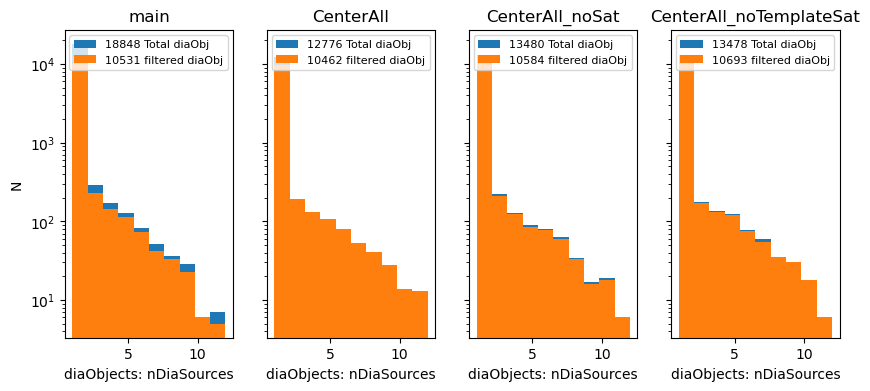

In [69]:
fig, axes = plt.subplots(1, 4, figsize=(10, 4), sharey=True)
for i_run, run_dict in enumerate([default_run, test_run, test_run2, test_run3]):
    #plt.figure(figsize=(12, 8))
    ax = axes.flatten()[i_run]

    ax.hist(run_dict['objTable'].nDiaSources, log=True, label=f"{len(run_dict['objTable'])} Total diaObj")
    #plt.xlabel('diaObjects: nDiaSources')
    #plt.legend(loc='best')

    ax.hist(run_dict['goodObj'].nDiaSources, log=True, label=f"{len(run_dict['goodObj'])} filtered diaObj")
    ax.set_xlabel('diaObjects: nDiaSources')
    ax.legend(loc='best', fontsize=8)
    ax.set_title(run_dict['run_name'])
axes.flatten()[0].set_ylabel('N')

Very few objects with >1 diaSource are flagged with one of our canonical "bad" flags after the *CenterAll flag cut

## 4.1 Real-bogus reliability scores

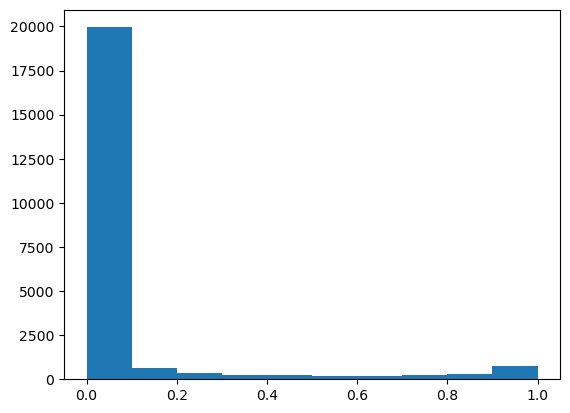

In [70]:
default_hist = plt.hist(default_run['srcTable']['reliability'])

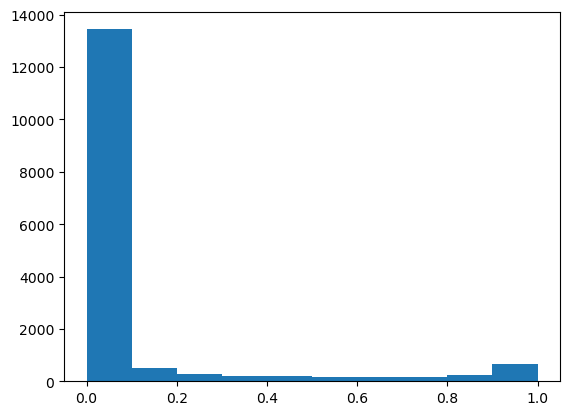

In [71]:
test_hist = plt.hist(test_run['srcTable']['reliability'])

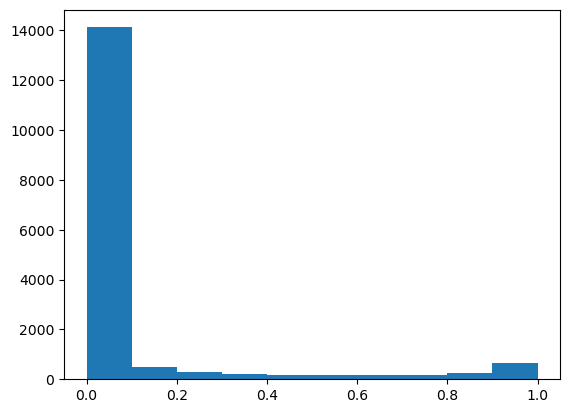

In [72]:
test_hist2 = plt.hist(test_run2['srcTable']['reliability'])

In [73]:
reliability_table = pd.DataFrame()

In [74]:
reliability_table['reliability'] = np.around(default_hist[1][:-1], 3)

In [75]:
reliability_table[default_run['run_name']] = default_hist[0]
reliability_table[test_run['run_name']] = test_hist[0]
reliability_table[test_run2['run_name']] = test_hist2[0]

In [76]:
reliability_table

reliability     main  CenterAll  CenterAll_noSat
0          0.0  19953.0    13438.0          14120.0
1          0.1    616.0      504.0            508.0
2          0.2    342.0      268.0            273.0
3          0.3    262.0      206.0            212.0
4          0.4    227.0      185.0            188.0
5          0.5    213.0      171.0            173.0
6          0.6    186.0      161.0            161.0
7          0.7    216.0      179.0            181.0
8          0.8    279.0      234.0            238.0
9          0.9    766.0      641.0            650.0

In [77]:
print(default_hist[1][5])
print(np.sum(default_hist[0][5:]))
print(np.sum(test_hist[0][5:]))
print(np.sum(test_hist2[0][5:]))

0.500000000000029
1660.0
1386.0
1403.0


### Repeat with only good sources

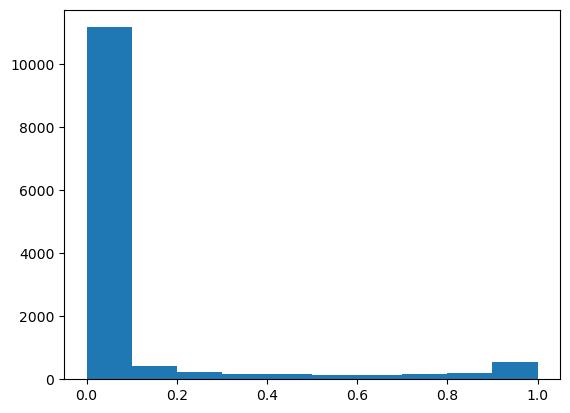

In [78]:
default_hist = plt.hist(default_run['goodSrc']['reliability'])

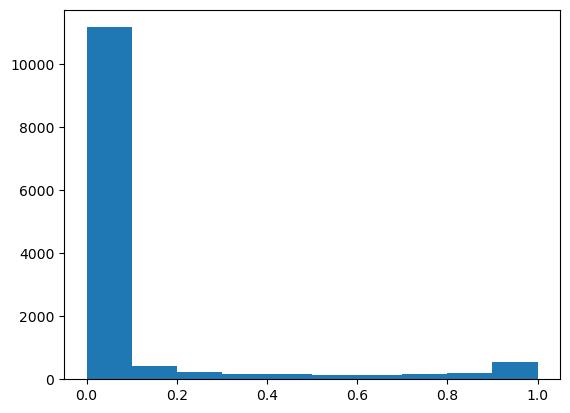

In [79]:
test_hist = plt.hist(test_run['goodSrc']['reliability'])

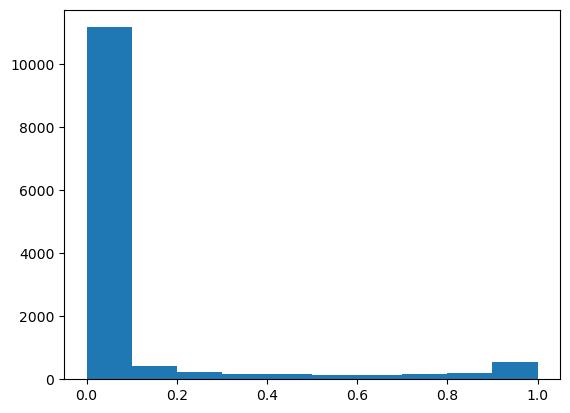

In [80]:
test_hist2 = plt.hist(test_run2['goodSrc']['reliability'])

In [81]:
reliability_table = pd.DataFrame()

In [82]:
reliability_table = pd.DataFrame()
reliability_table['reliability'] = np.around(default_hist[1][:-1], 3)
reliability_table[default_run['run_name']] = default_hist[0]
reliability_table[test_run['run_name']] = test_hist[0]
reliability_table[test_run2['run_name']] = test_hist2[0]

In [83]:
reliability_table

reliability     main  CenterAll  CenterAll_noSat
0          0.0  11169.0    11169.0          11169.0
1          0.1    421.0      421.0            421.0
2          0.2    222.0      222.0            222.0
3          0.3    177.0      177.0            177.0
4          0.4    158.0      158.0            158.0
5          0.5    149.0      149.0            149.0
6          0.6    141.0      141.0            141.0
7          0.7    154.0      154.0            154.0
8          0.8    203.0      203.0            203.0
9          0.9    562.0      562.0            562.0

In [84]:
print(default_hist[1][5])
print(np.sum(default_hist[0][5:]))
print(np.sum(test_hist[0][5:]))
print(np.sum(test_hist2[0][5:]))

0.5000000000165539
1209.0
1209.0
1209.0


There is much less of a difference seen between the objects that are flagged as "good". 

## 5. Sky plots on sources

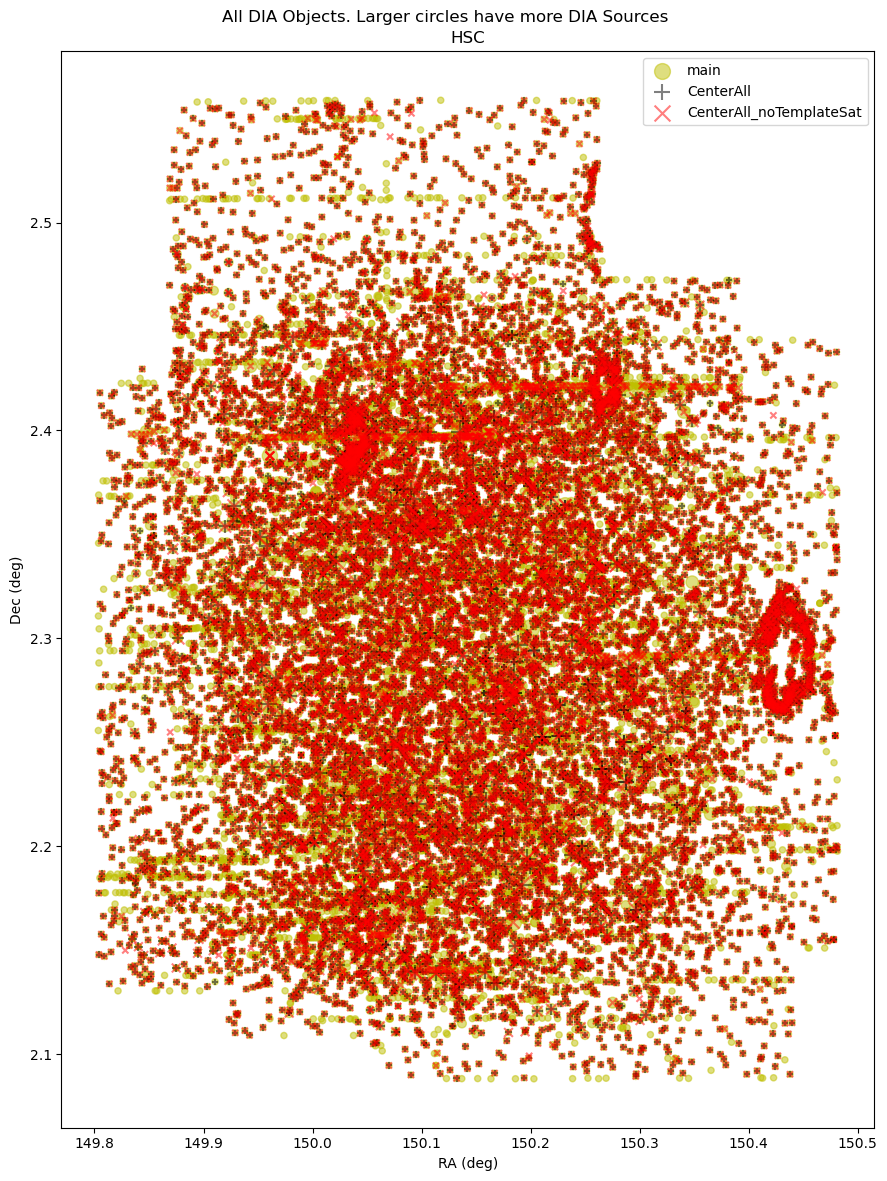

In [85]:
nSrc = 0  # threshold for which DIA Objects to plot (only those with > nSrc constituent DIA Sources)

fig, ax = plt.subplots(1, 1, figsize=(9, 12), sharex=True, sharey=True)

fig.suptitle('All DIA Objects. Larger circles have more DIA Sources')

for i_run, run_dict in enumerate([default_run, test_run, test_run3]):

#     xlim = [149.7, 149.5]
#     ylim = [2.7, 2.9]
    #plt.setp(axs, xlim=xlim, ylim=ylim)
    
    goodFilter = (run_dict['objTable']['nDiaSources'] > nSrc)
#     goodFilter = run_dict[]
    
#     axG = axs[i_run]
    ax.set_ylabel('Dec (deg)')
    if i_run==2:
        ax.set_xlabel('RA (deg)')
    if i_run==0:
        ax.set_title('HSC')
    
    colorList = ['y', 'k', 'r']
    markerList = ['o', '+', 'x']

    ax.scatter(run_dict['objTable'].loc[goodFilter, 'ra'],
               run_dict['objTable'].loc[goodFilter, 'dec'],
               s=run_dict['objTable'].loc[goodFilter, 'nDiaSources']*20, 
               c=colorList[i_run], marker=markerList[i_run], alpha=0.5,
               label=run_dict['run_name'])
    ax.legend(loc='upper right')
#     axR.legend(loc='upper right')
plt.tight_layout()

In [86]:
table_test = run_dict['goodObj']

In [87]:
table_test.columns

Index(['diaObjectId', 'ra', 'dec', 'nDiaSources', 'g_psfFluxMean',
       'r_psfFluxMean', 'i_psfFluxMean', 'z_psfFluxMean', 'y_psfFluxMean',
       'validityEnd', 'flags'],
      dtype='object')

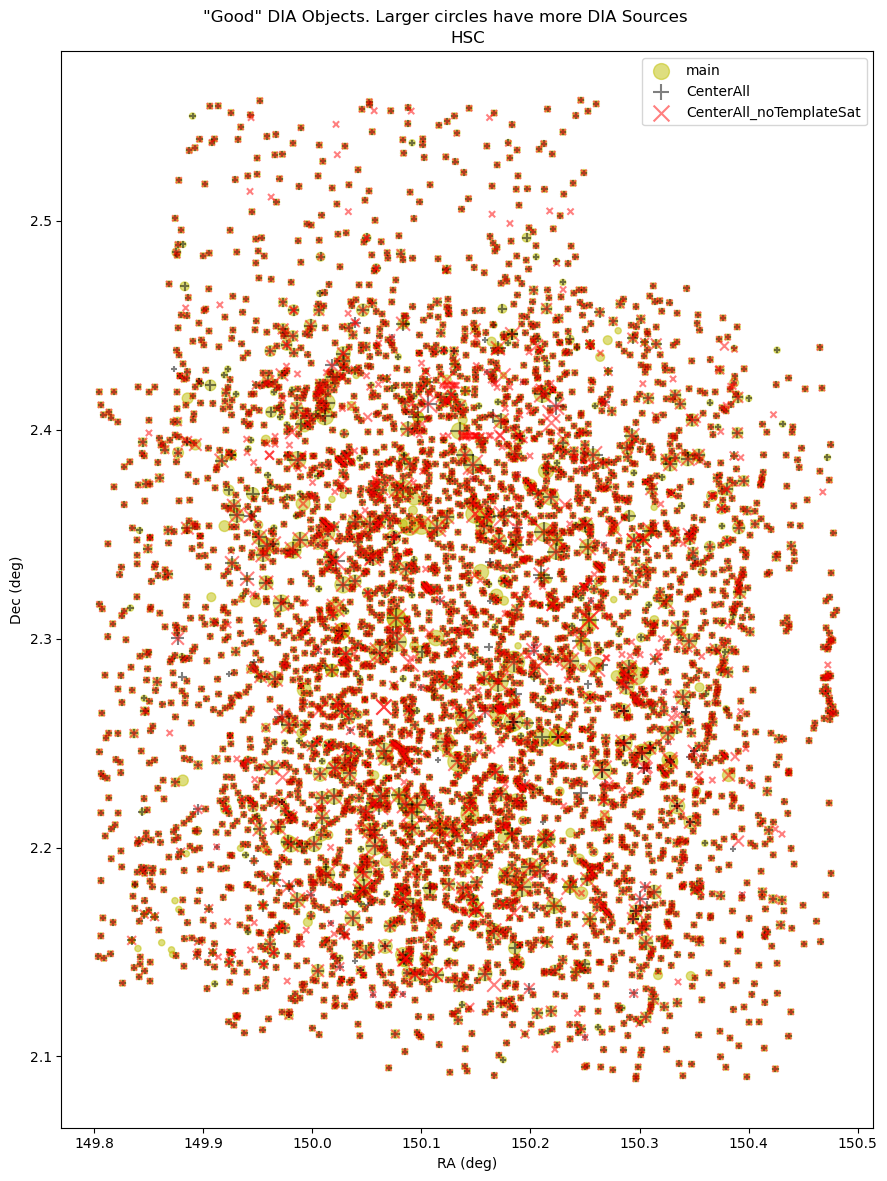

In [88]:
nSrc = 0  # threshold for which DIA Objects to plot (only those with > nSrc constituent DIA Sources)

fig, ax = plt.subplots(1, 1, figsize=(9, 12), sharex=True, sharey=True)

fig.suptitle('"Good" DIA Objects. Larger circles have more DIA Sources')

for i_run, run_dict in enumerate([default_run, test_run, test_run3]):

#     xlim = [149.7, 149.5]
#     ylim = [2.7, 2.9]
    #plt.setp(axs, xlim=xlim, ylim=ylim)
    
    goodFilter = (run_dict['goodObj']['nDiaSources'] > nSrc) &\
                 (run_dict['goodObj']['g_psfFluxMean'] > 0)
#     goodFilter = run_dict[]
    
#     axG = axs[i_run]
    ax.set_ylabel('Dec (deg)')
    if i_run==2:
        ax.set_xlabel('RA (deg)')
    if i_run==0:
        ax.set_title('HSC')
    
    colorList = ['y', 'k', 'r']
    markerList = ['o', '+', 'x']

    ax.scatter(run_dict['goodObj'].loc[goodFilter, 'ra'],
               run_dict['goodObj'].loc[goodFilter, 'dec'],
               s=run_dict['goodObj'].loc[goodFilter, 'nDiaSources']*20, 
               c=colorList[i_run], marker=markerList[i_run], alpha=0.5,
               label=run_dict['run_name'])
    ax.legend(loc='upper right')
#     axR.legend(loc='upper right')
plt.tight_layout()

## 4.2 Comparison of diaSources between runs

In [89]:
objectTable = default_run['goodObj']
objectTable1 = test_run['goodObj']
objectTable2 = test_run2['goodObj']
objectTable3 = test_run3['goodObj']

In [90]:
objectTable.columns

Index(['diaObjectId', 'ra', 'dec', 'nDiaSources', 'g_psfFluxMean',
       'r_psfFluxMean', 'i_psfFluxMean', 'z_psfFluxMean', 'y_psfFluxMean',
       'validityEnd', 'flags'],
      dtype='object')

In [91]:
obj_default, obj_test, obj_match = nb_utils.compare_sources(default_run['butler'], test_run['butler'],
                                                            default_run['reader'], test_run['reader'],
                                                            match_radius=0.1, display_cutouts=False,
                                                            bad_flag_list=badFlagList,
                                                            make_cutouts=False)

13356 matched sources; 0 unique to set 1; 12 unique to set 2.


In [92]:
obj_default2, obj_test2, obj_match2 = nb_utils.compare_sources(default_run['butler'], test_run2['butler'],
                                                               default_run['reader'], test_run2['reader'],
                                                               match_radius=0.1, display_cutouts=False,
                                                               bad_flag_list=badFlagList,
                                                               make_cutouts=False)

13356 matched sources; 0 unique to set 1; 12 unique to set 2.


In [93]:
obj_default3, obj_test3, obj_match3 = nb_utils.compare_sources(default_run['butler'], test_run3['butler'],
                                                               default_run['reader'], test_run3['reader'],
                                                               match_radius=0.1, display_cutouts=False,
                                                               bad_flag_list=badFlagList,
                                                               make_cutouts=False)

12763 matched sources; 593 unique to set 1; 798 unique to set 2.


In [94]:
highObs_default = obj_default.diaSourceId[obj_default['reliability'] > 0.1]

In [95]:
highObs_test = obj_test.diaSourceId[obj_test['reliability'] > 0.1]

In [96]:
len(highObs_default)

0

In [97]:
len(highObs_test)

4

In [98]:
!pwd

/home/s/sullii/notebooks/ap_pipe-notebooks/notebooks


In [99]:
all_default, all_test, all_match = nb_utils.compare_sources(default_run['butler'], test_run['butler'],
                                                            default_run['reader'], test_run['reader'],
                                                            match_radius=0.1, display_cutouts=False,
                                                            bad_flag_list=[],
                                                            make_cutouts=False)

15987 matched sources; 7073 unique to set 1; 26 unique to set 2.


In [100]:
all_default2, all_test2, all_match2 = nb_utils.compare_sources(default_run['butler'], test_run2['butler'],
                                                               default_run['reader'], test_run2['reader'],
                                                               match_radius=0.1, display_cutouts=False,
                                                               bad_flag_list=[],
                                                               make_cutouts=False)

16704 matched sources; 6356 unique to set 1; 27 unique to set 2.


In [101]:
all_default3, all_test3, all_match3 = nb_utils.compare_sources(default_run['butler'], test_run3['butler'],
                                                               default_run['reader'], test_run3['reader'],
                                                               match_radius=0.1, display_cutouts=False,
                                                               bad_flag_list=[],
                                                               make_cutouts=False)

16023 matched sources; 7037 unique to set 1; 764 unique to set 2.


In [100]:
all_default3b, all_test3b, all_match3b = nb_utils.compare_sources(test_run2['butler'], test_run3['butler'],
                                                                  test_run2['reader'], test_run3['reader'],
                                                                  match_radius=0.2, display_cutouts=False,
                                                                  bad_flag_list=[],
                                                                  cutout_path1='../../../project/tickets/DM-41875/cutouts3/centerAll_noSat',
                                                                  cutout_path2='../../../project/tickets/DM-41875/cutouts3/centerAll_noTemplateSat',
                                                                  make_cutouts=True)

16164 matched sources; 540 unique to set 1; 623 unique to set 2.


In [102]:
cut_all, cut_noSat, cut_match = nb_utils.compare_sources(test_run['butler'], test_run2['butler'],
                                                         test_run['reader'], test_run2['reader'],
                                                         match_radius=0.1, display_cutouts=False,
                                                         bad_flag_list=[],
                                                         make_cutouts=False)

15987 matched sources; 0 unique to set 1; 743 unique to set 2.


In [91]:
cut_all, cut_noSat, cut_match = nb_utils.compare_sources(test_run['butler'], test_run2['butler'],
                                                         test_run['reader'], test_run2['reader'],
                                                         match_radius=0.1, display_cutouts=False,
                                                         bad_flag_list=[],
                                                         cutout_path1='../../../project/tickets/DM-41875/cutouts2/centerAll',
                                                         cutout_path2='../../../project/tickets/DM-41875/cutouts2/centerAll_noSat',
                                                         make_cutouts=True)

15987 matched sources; 0 unique to set 1; 743 unique to set 2.


In [81]:
all_default, all_test, all_match = nb_utils.compare_sources(default_run['butler'], test_run['butler'],
                                                            default_run['reader'], test_run['reader'],
                                                            match_radius=0.1, display_cutouts=False,
                                                            bad_flag_list=[],
                                                            cutout_path1='../../../project/tickets/DM-41875/cutouts/main',
                                                            cutout_path2='../../../project/tickets/DM-41875/cutouts/centerAll',
                                                            make_cutouts=True)

15987 matched sources; 7073 unique to set 1; 26 unique to set 2.


## 6. Cutouts

### 7. Flag frequency analysis

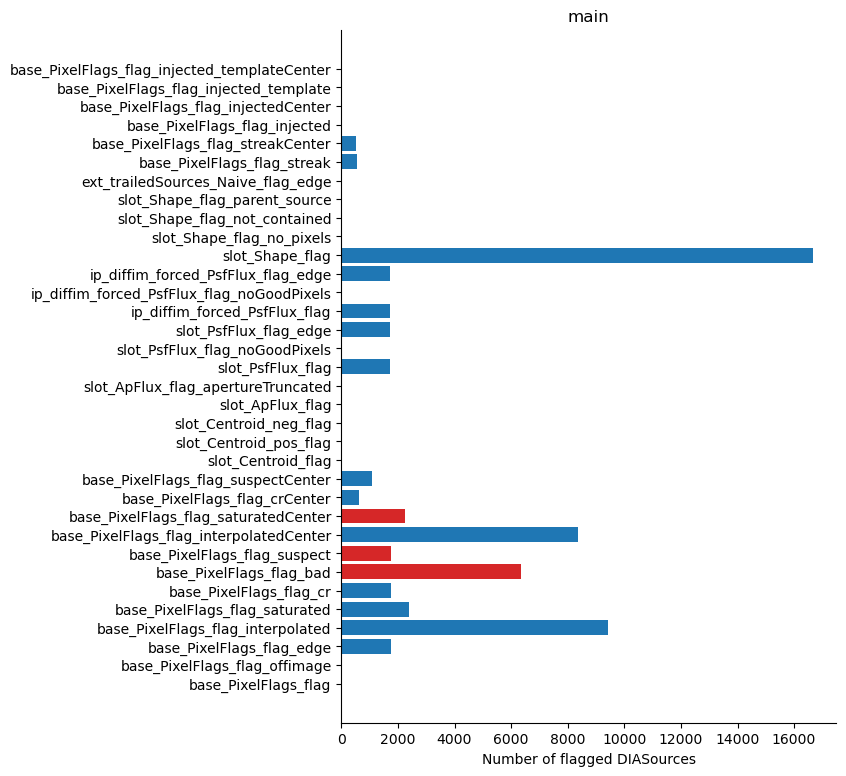

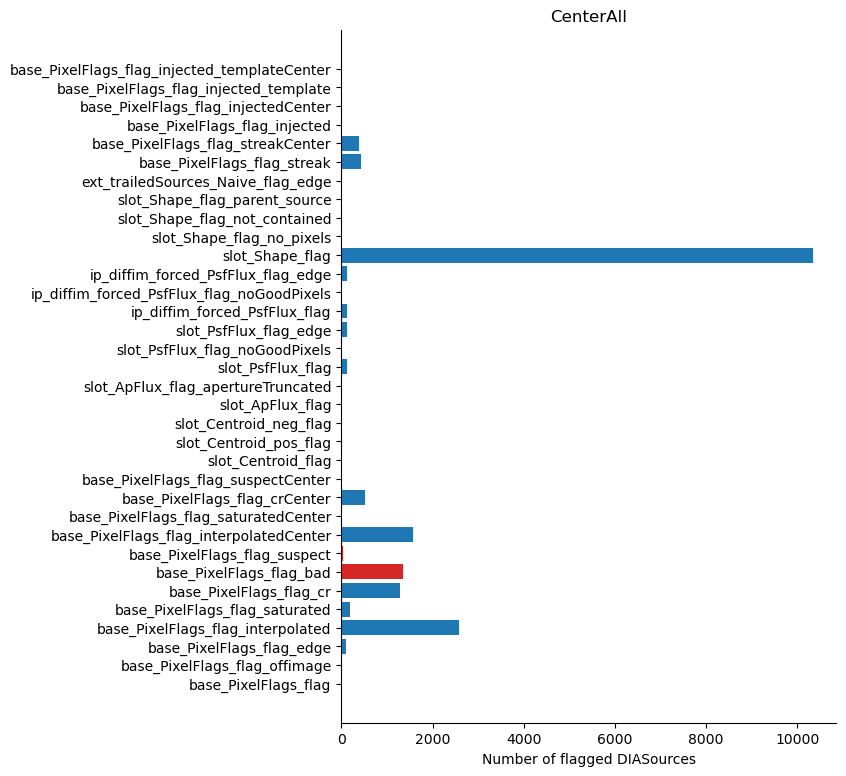

In [103]:
for arun in [default_run, test_run]:
    repo = arun['repo']
    goodSrc = arun['goodSrc']
    collections = arun['collections']
    srcTable = arun['srcTable']
    
    plac.plotFlagHist(srcTable, title=f'{arun["run_name"]}')

### 8. diaSource reliability score

Not really part of this ticket, but since we have all the sources available let's compare diaSource reliability scores from real-bogus between runs.

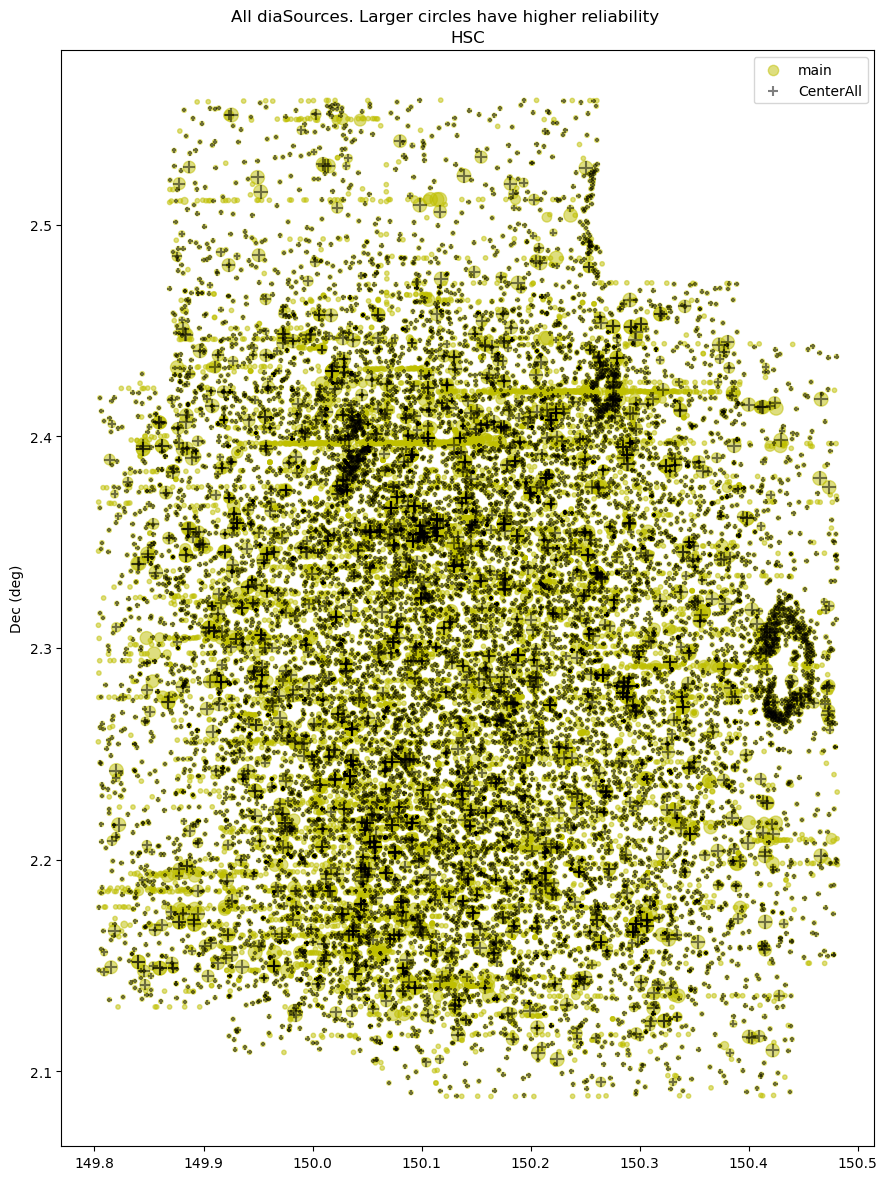

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(9, 12), sharex=True, sharey=True)

fig.suptitle('All diaSources. Larger circles have higher reliability')

for i_run, run_dict in enumerate([default_run, test_run]):

    ax.set_ylabel('Dec (deg)')
    if i_run==2:
        ax.set_xlabel('RA (deg)')
    if i_run==0:
        ax.set_title('HSC')
    
    colorList = ['y', 'k', 'r']
    markerList = ['o', '+', 'x']
    sizes = run_dict['srcTable']['reliability']*100
    sizes = [max([s, 10]) for s in sizes]

    ax.scatter(run_dict['srcTable']['ra'],
               run_dict['srcTable']['dec'],
               s=sizes, 
               c=colorList[i_run], marker=markerList[i_run], alpha=0.5,
               label=run_dict['run_name'])
    ax.legend(loc='upper right')
#     axR.legend(loc='upper right')
plt.tight_layout()

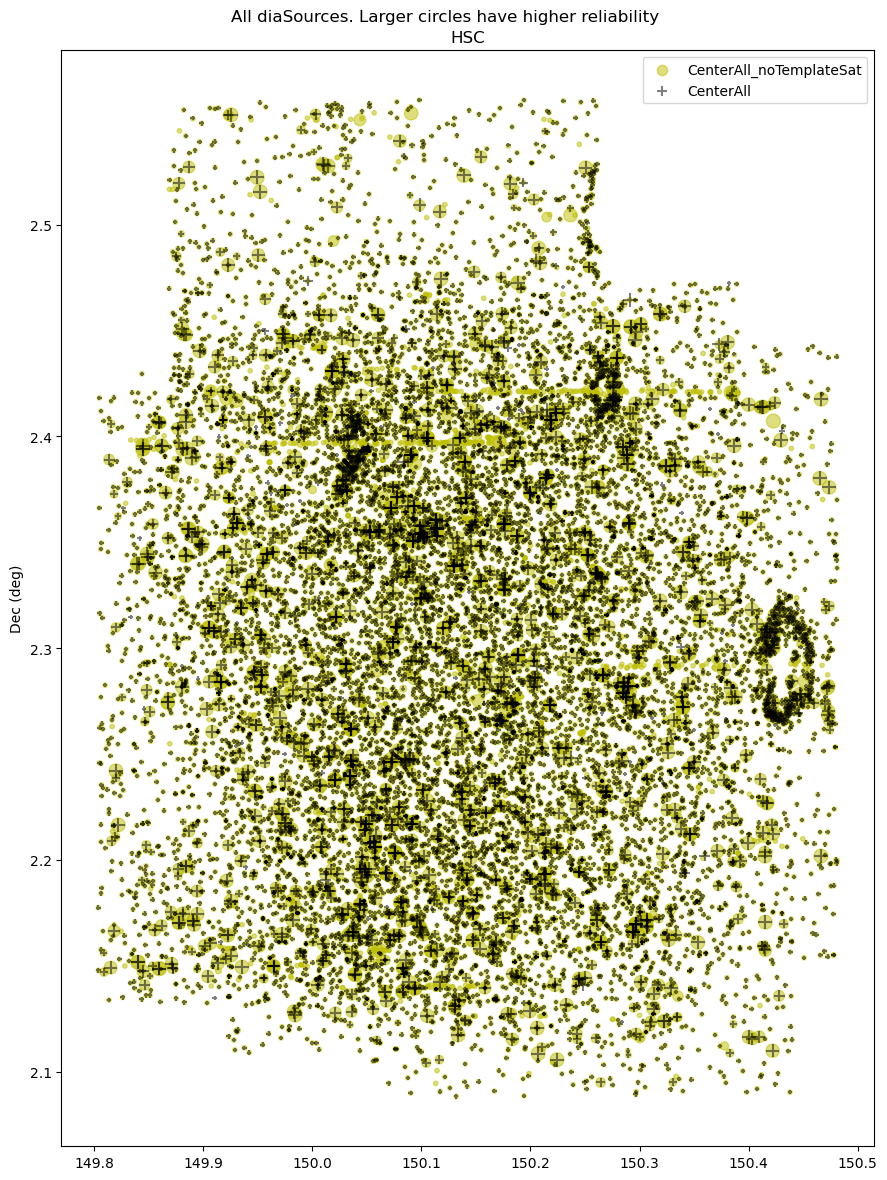

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(9, 12), sharex=True, sharey=True)

fig.suptitle('All diaSources. Larger circles have higher reliability')

for i_run, run_dict in enumerate([test_run3, test_run]):

    ax.set_ylabel('Dec (deg)')
    if i_run==2:
        ax.set_xlabel('RA (deg)')
    if i_run==0:
        ax.set_title('HSC')
    
    colorList = ['y', 'k', 'r']
    markerList = ['o', '+', 'x']
    sizes = run_dict['srcTable']['reliability']*100
    sizes = [max([s, 10]) for s in sizes]

    ax.scatter(run_dict['srcTable']['ra'],
               run_dict['srcTable']['dec'],
               s=sizes, 
               c=colorList[i_run], marker=markerList[i_run], alpha=0.5,
               label=run_dict['run_name'])
    ax.legend(loc='upper right')
#     axR.legend(loc='upper right')
plt.tight_layout()

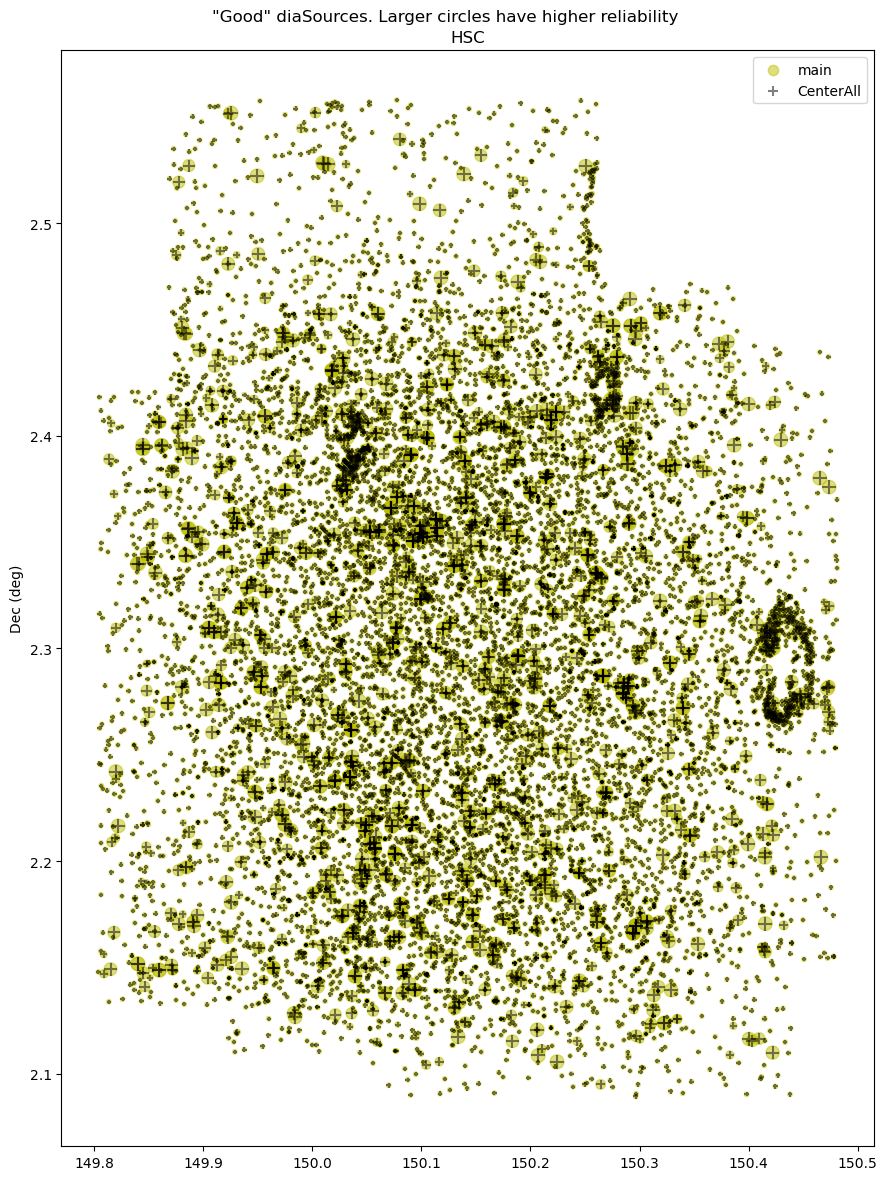

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(9, 12), sharex=True, sharey=True)

fig.suptitle('"Good" diaSources. Larger circles have higher reliability')

for i_run, run_dict in enumerate([default_run, test_run]):

    ax.set_ylabel('Dec (deg)')
    if i_run==2:
        ax.set_xlabel('RA (deg)')
    if i_run==0:
        ax.set_title('HSC')
    
    colorList = ['y', 'k', 'r']
    markerList = ['o', '+', 'x']
    sizes = run_dict['goodSrc']['reliability']*100
    sizes = [max([s, 10]) for s in sizes]

    ax.scatter(run_dict['goodSrc']['ra'],
               run_dict['goodSrc']['dec'],
               s=sizes, 
               c=colorList[i_run], marker=markerList[i_run], alpha=0.5,
               label=run_dict['run_name'])
    ax.legend(loc='upper right')
#     axR.legend(loc='upper right')
plt.tight_layout()

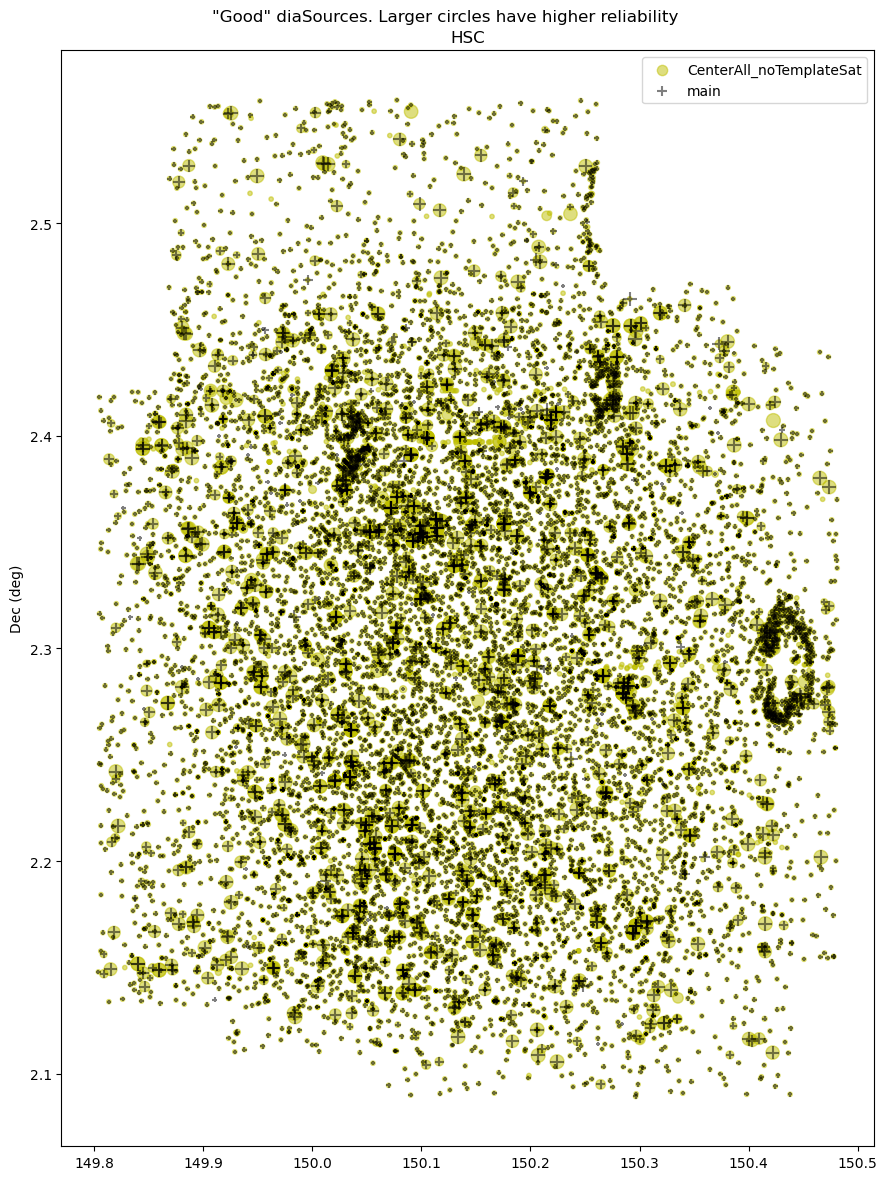

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(9, 12), sharex=True, sharey=True)

fig.suptitle('"Good" diaSources. Larger circles have higher reliability')

for i_run, run_dict in enumerate([test_run3, default_run]):

    ax.set_ylabel('Dec (deg)')
    if i_run==2:
        ax.set_xlabel('RA (deg)')
    if i_run==0:
        ax.set_title('HSC')
    
    colorList = ['y', 'k', 'r']
    markerList = ['o', '+', 'x']
    sizes = run_dict['goodSrc']['reliability']*100
    sizes = [max([s, 10]) for s in sizes]

    ax.scatter(run_dict['goodSrc']['ra'],
               run_dict['goodSrc']['dec'],
               s=sizes, 
               c=colorList[i_run], marker=markerList[i_run], alpha=0.5,
               label=run_dict['run_name'])
    ax.legend(loc='upper right')
#     axR.legend(loc='upper right')
plt.tight_layout()

# Conclusions

* Excluding diaSources with any of the following flags significantly cuts the number of diaSources we later reject as bad, and does not appear to remove any good sources:
* * base_PixelFlags_flag_interpolatedCenterAll
* * base_PixelFlags_flag_badCenterAll
* * base_PixelFlags_flag_suspectCenterAll
* Removing base_PixelFlags_flag_saturatedCenterAll flagged sources removes many bad sources, but also includes some sources that are not obviously bad.
* If the saturated mask plane is not propagated from the template, and all of the above *CenterAll flagged sources are removed, we appear to recover a small number of "good" diaSources that were previously flagged.
